# Import Packages and Read Data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [2]:
prof_data = pd.read_csv('profile_data.csv',index_col=0)
data = pd.read_excel('performance_data_with_dec_score.xlsx',index_col=0)
data

,slug,date,marketcap_usd,amount_in_top_holders,social_volume_total,sentiment_positive_total,sentiment_negative_total,dev_activity,github_activity,dev_activity_contributors_count,dec_score
0,enecuum,2019-12-11,939828.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Centralized > Hierarchical
1,enecuum,2019-12-12,978550.0,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,Centralized > Hierarchical
2,enecuum,2019-12-13,1009804.0,1.217092e+08,0.0,0.000000,0.0,0.0,0.0,0.0,Centralized > Hierarchical
3,enecuum,2019-12-14,931420.0,1.217263e+08,0.0,0.000000,0.0,0.0,0.0,0.0,Centralized > Hierarchical
4,enecuum,2019-12-15,914745.0,1.217662e+08,0.0,0.000000,0.0,0.0,0.0,0.0,Centralized > Hierarchical
...,...,...,...,...,...,...,...,...,...,...,...
185191,sapphire,2021-12-07,242854453.0,4.815453e+05,11.0,2.382749,0.0,0.0,0.0,0.0,Decentralized
185192,sapphire,2021-12-08,241091714.0,4.821779e+05,3.0,1.563417,0.0,0.0,0.0,0.0,Decentralized
185193,sapphire,2021-12-09,227697891.0,4.989043e+05,0.0,0.000000,0.0,0.0,0.0,0.0,Decentralized
185194,sapphire,2021-12-10,226242364.0,4.983487e+05,5.0,3.002579,0.0,0.0,0.0,0.0,Decentralized


In [3]:
# add a type column (layer 1, 2)
type_list = []
missed = []
for i in data['slug']:
    try:
        type_list.append(prof_data[prof_data['slug']==i].iloc[0].type)
    except:
        type_list.append('missing')

data['type'] = type_list

# Polynomial Regression on Market Cap and Dec Score

In [5]:
btc_price = pd.read_csv('BTC-USD.csv')
btc_price = btc_price[['Date','Close']]
date = '2021-12-01'

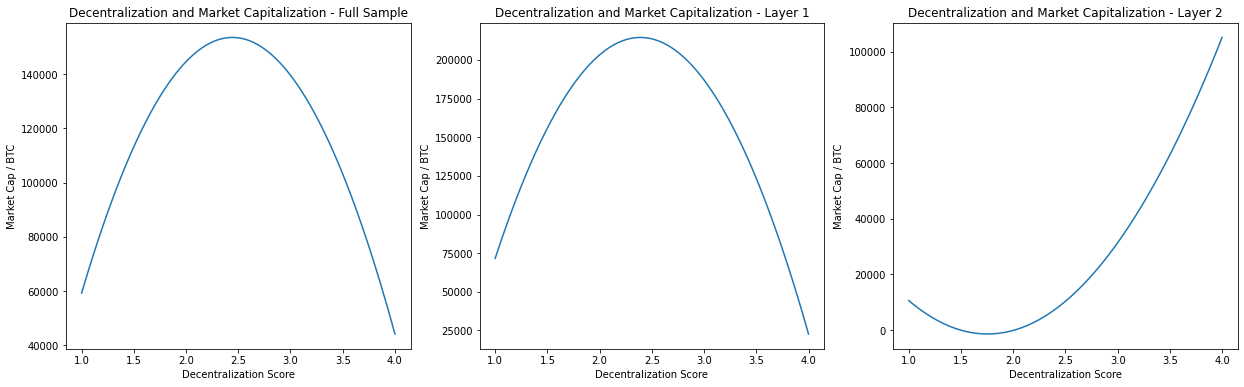

In [285]:
fig, ax1 = plt.subplots(1,3, figsize=(21, 6))

for i in range(3):
    if i == 0: # full sample
        market_dec = data[(data['date']==date)][['slug','dec_score','marketcap_usd']].dropna()
        plot_title = 'Decentralization and Market Capitalization - Full Sample'
    elif i == 1: # layer 1
        market_dec = data[(data['date']==date) & (data['type']=='coin')][['slug','dec_score','marketcap_usd']].dropna()
        plot_title = 'Decentralization and Market Capitalization - Layer 1'
    else: # layer 2
        market_dec = data[(data['date']==date) & (data['type']=='token')][['slug','dec_score','marketcap_usd']].dropna()
        plot_title = 'Decentralization and Market Capitalization - Layer 2'
        
    # map score into integers
    order_list = ['Centralized > Hierarchical','Centralized > Flat','Semi-centralized','Decentralized']
    score_map = dict(zip(order_list,list(range(1,5))))
    market_dec['dec_score'] = market_dec['dec_score'].map(score_map)

    # drop max
    market_dec = market_dec.loc[market_dec['marketcap_usd']!=market_dec['marketcap_usd'].max()]
    # market_dec.drop(market_dec[market_dec['slug'].isin(['bitcoin'])].index.to_list(),inplace=True)

    # adjust market cap unit to btc to account for market cycle
    unit = btc_price[btc_price['Date']==date]['Close'].values[0]
    market_dec['marketcap_btc'] = market_dec['marketcap_usd']/unit
    
    # initialize linear model
    poly_reg = LinearRegression()
    poly = PolynomialFeatures(degree=2, include_bias=False)

    x_poly = poly.fit_transform(market_dec[['dec_score']])
    poly_reg.fit(x_poly,market_dec['marketcap_btc'])
    # print('y={}x^2 + {}x + {}'.format(poly_reg.coef_[1], poly_reg.coef_[0],poly_reg.intercept_))

    # plotting
    vis_x = np.linspace(1,4,100)
    vis_y = poly_reg.coef_[0]*vis_x + poly_reg.coef_[1]*vis_x**2 + poly_reg.intercept_
    
    ax1[i].set_ylabel('Market Cap / BTC')
    ax1[i].set_xlabel('Decentralization Score')
    ax1[i].set_title(plot_title)
    ax1[i].plot(vis_x,vis_y)

# Polynomial Regression with Other Variables

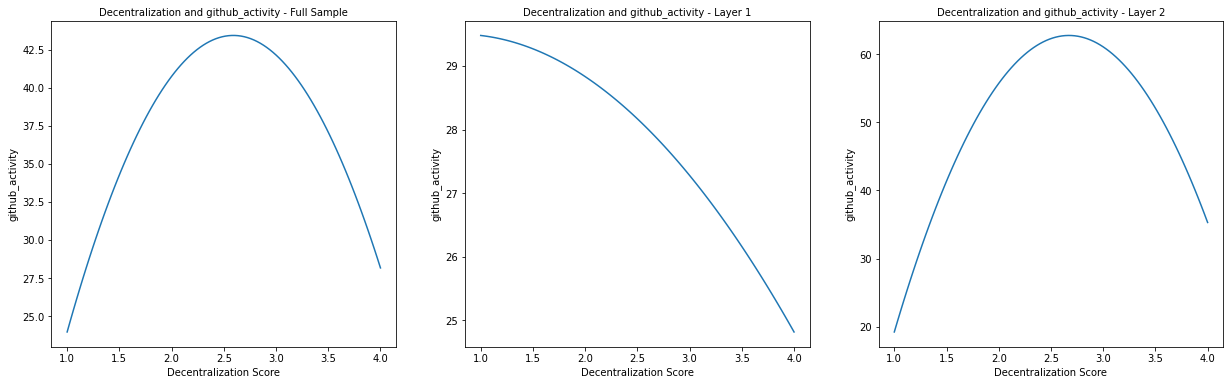

In [295]:
fig, ax2 = plt.subplots(1,3, figsize=(21, 6))

# amount_in_top_holders, social_volume_total, sentiment_positive_total,
# sentiment_negative_total, dev_activity, github_activity, dev_activity_contributors_count
var = 'github_activity' 

for i in range(3):
    if i == 0: # full sample
        dec_var_df = data[(data['date']==date)][['slug','dec_score',var]].dropna()
        plot_title = 'Decentralization and {} - Full Sample'.format(var)
    elif i == 1: # layer 1
        dec_var_df = data[(data['date']==date) & (data['type']=='coin')][['slug','dec_score',var]].dropna()
        plot_title = 'Decentralization and {} - Layer 1'.format(var)
    else: # layer 2
        dec_var_df = data[(data['date']==date) & (data['type']=='token')][['slug','dec_score',var]].dropna()
        plot_title = 'Decentralization and {} - Layer 2'.format(var)

    # drop max
    dec_var_df = dec_var_df.loc[dec_var_df[var]!=dec_var_df[var].max()]


    # map score into integers
    order_list = ['Centralized > Hierarchical','Centralized > Flat','Semi-centralized','Decentralized']
    score_map = dict(zip(order_list,list(range(1,5))))
    dec_var_df['dec_score'] = dec_var_df['dec_score'].map(score_map)
    
    # initialize linear model
    poly_reg = LinearRegression()
    poly = PolynomialFeatures(degree=2, include_bias=False)

    x_poly = poly.fit_transform(dec_var_df[['dec_score']])
    poly_reg.fit(x_poly,dec_var_df[var])
    # print('y={}x^2 + {}x + {}'.format(poly_reg.coef_[1], poly_reg.coef_[0],poly_reg.intercept_))

    # plotting
    vis_x = np.linspace(1,4,100)
    vis_y = poly_reg.coef_[0]*vis_x + poly_reg.coef_[1]*vis_x**2 + poly_reg.intercept_

    ax2[i].set_ylabel(var)
    ax2[i].set_xlabel('Decentralization Score')
    ax2[i].set_title(plot_title, size=10)
    ax2[i].plot(vis_x,vis_y)

# Decentralization with other performance metrics

In [53]:
# dev activity (data['type']=='token') & 
dec_dev = pd.DataFrame(np.mean(data[(data['type']=='token') & (data['dec_score']==order_list[i])].groupby('slug').describe()['dev_activity'][['mean','std','50%','max']]))
dec_dev.columns = [order_list[0]]
for i in range(1,4):
    dec_dev[order_list[i]] = list(np.mean(data[(data['type']=='token') & (data['dec_score']==order_list[i])].groupby('slug').describe()['dev_activity'][['mean','std','50%','max']]))
dec_dev = dec_dev.T

In [59]:
# social sentiment (data['type']=='token') & 
dec_soc = pd.DataFrame(np.mean(data[(data['dec_score']==order_list[i])].groupby('slug').describe()['sentiment_negative_total'][['mean','std','50%','max']]))
dec_soc.columns = [order_list[0]]
for i in range(1,4):
    dec_soc[order_list[i]] = list(np.mean(data[(data['dec_score']==order_list[i])].groupby('slug').describe()['sentiment_negative_total'][['mean','std','50%','max']]))
dec_soc = dec_dev.T

In [60]:
dec_soc

,Centralized > Hierarchical,Centralized > Flat,Semi-centralized,Decentralized
mean,12.664752,11.051277,38.337053,12.664752
std,13.867644,13.633007,33.943710,13.867644
50%,8.333333,6.333333,34.916667,8.333333
max,115.388889,101.333333,189.083333,115.388889


# Machine Learning

## Predict the percentage change of market cap

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,ElasticNet,Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [161]:
slug_exclude = ['bitcoin']
# four additional slugs that contain 0 in marketcap time series, which causes nan when calculating the percentage change
with_zero = ['wagerr', 'counterparty', 'microbitcoin', 'dimecoin']
slug_exclude.extend(with_zero)

for i in data.slug.unique():
    mkt_series = data[data['slug']==i].marketcap_usd
    if len(mkt_series) != len(mkt_series.dropna()) or mkt_series.iloc[0]==0: # drop series with empty entries
        slug_exclude.append(i)

data_filtered = data[~data['slug'].isin(slug_exclude)]

In [162]:
data_filtered = data_filtered.bfill().ffill()
data_filtered = data_filtered.reset_index().drop(columns='index')
# 'dec_score' is removed
data_filtered = data_filtered[['slug','date','marketcap_usd','social_volume_total','sentiment_positive_total','sentiment_negative_total','dec_score']]

# denominate by btc price
mkt_btc = []
btc_prices = btc_price[(btc_price['Date']>='2019-12-11') & (btc_price['Date']<='2021-12-11')]['Close'] # btc prices within date range
for i in data_filtered.slug.unique():
    mkt_btc.extend(list(data_filtered[data_filtered['slug']==i]['marketcap_usd']/np.array(btc_prices)))
data_filtered['marketcap_btc'] = mkt_btc

print(data_filtered.shape)
print('{} projects are included after the filtering'.format(data_filtered.shape[0]/732))
data_filtered.head()

(154452, 8)
211.0 projects are included after the filtering


,slug,date,marketcap_usd,social_volume_total,sentiment_positive_total,sentiment_negative_total,dec_score,marketcap_btc
0,enecuum,2019-12-11,939828.0,0.0,0.0,0.0,Centralized > Hierarchical,130.216484
1,enecuum,2019-12-12,978550.0,0.0,0.0,0.0,Centralized > Hierarchical,135.100353
2,enecuum,2019-12-13,1009804.0,0.0,0.0,0.0,Centralized > Hierarchical,138.906164
3,enecuum,2019-12-14,931420.0,0.0,0.0,0.0,Centralized > Hierarchical,130.731599
4,enecuum,2019-12-15,914745.0,0.0,0.0,0.0,Centralized > Hierarchical,127.895191


In [163]:
# one-hot encode the slugs
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(data_filtered[['slug']]).toarray())

# change the column name of encoding df from integers to the corresponding slug name
col_name = []
for i in range(enc_df.shape[1]):
    tmp = enc_df.loc[:,i]
    col_name.append(data_filtered['slug'].loc[tmp[tmp==1].index[0]])
enc_df.columns = col_name

# add encoded df to dataframe
data_enc = data_filtered.join(enc_df) # join properly requires index to be the same

order_list = ['Centralized > Hierarchical','Centralized > Flat','Semi-centralized','Decentralized']
score_map = dict(zip(order_list,list(range(1,5))))
data_enc['dec_score'] = data_enc['dec_score'].map(score_map)

In [164]:
data_enc.set_index('date',inplace=True)

# select coin/token or all samples
# data_enc = data_enc[data_enc['type']=='coin']

data_enc.drop(columns=['slug','marketcap_usd'],inplace=True)

print(data_enc.shape)
data_enc.head()

(154452, 216)


,social_volume_total,sentiment_positive_total,sentiment_negative_total,dec_score,marketcap_btc,0x,abbc-coin,achain,adshares,aelf,...,vite,wanchain,waves,wax,waykichain,wrapped-bitcoin,xyo,zcash,zclassic,zencash
date,,,,,,,,,,,,,,,,,,,,,
2019-12-11,0.0,0.0,0.0,1,130.216484,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-12,0.0,0.0,0.0,1,135.100353,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-13,0.0,0.0,0.0,1,138.906164,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-14,0.0,0.0,0.0,1,130.731599,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-15,0.0,0.0,0.0,1,127.895191,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
# add column percentage change
pct_change = []
for i in range(enc_df.shape[1]):
    cur_df = data_enc[i*len(data_enc.index.unique()):(i+1)*len(data_enc.index.unique())]
    pct_series = cur_df['marketcap_btc'].pct_change()
    pct_change.extend(list(pct_series))

data_enc['marketcap_pct_change'] = pct_change

# the start is nan since it has no denominator so they have to be dropped, and we are left with 731 days (212 projects)
data_enc = data_enc.loc[data_enc.index != '2019-12-11']
data_enc = data_enc.drop(columns='marketcap_btc')
data_enc.head()

,social_volume_total,sentiment_positive_total,sentiment_negative_total,dec_score,0x,abbc-coin,achain,adshares,aelf,aeon,...,wanchain,waves,wax,waykichain,wrapped-bitcoin,xyo,zcash,zclassic,zencash,marketcap_pct_change
date,,,,,,,,,,,,,,,,,,,,,
2019-12-12,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037506
2019-12-13,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028170
2019-12-14,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058850
2019-12-15,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021696
2019-12-16,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.100682


In [166]:
# add window
data_enc['marketcap_pct_change_1'] = data_enc['marketcap_pct_change'].shift(7)
data_enc['marketcap_pct_change_2'] = data_enc['marketcap_pct_change'].shift(6)
data_enc['marketcap_pct_change_3'] = data_enc['marketcap_pct_change'].shift(5)
data_enc['marketcap_pct_change_4'] = data_enc['marketcap_pct_change'].shift(4)
data_enc['marketcap_pct_change_5'] = data_enc['marketcap_pct_change'].shift(3)
data_enc['marketcap_pct_change_6'] = data_enc['marketcap_pct_change'].shift(2)
data_enc['marketcap_pct_change_7'] = data_enc['marketcap_pct_change'].shift(1)
data_enc.dropna(inplace=True)

In [167]:
# split time series into 0.75 train and 0.25 test data
len_train = int(len(data_enc.index.unique()) * 0.75)
train_date = list(data_enc.index.unique())[:len_train]
test_date = list(data_enc.index.unique())[len_train:]
len_test = len(test_date)

# train test split
train_data = data_enc.loc[train_date]
test_data = data_enc.loc[test_date]

In [168]:
X_train = train_data.drop(columns=['marketcap_pct_change'])
y_train = np.array(train_data['marketcap_pct_change'])
X_test = test_data.drop(columns=['marketcap_pct_change'])
y_test = np.array(test_data['marketcap_pct_change'])

In [169]:
mlp_reg = MLPRegressor(alpha = 0.008, random_state=42, max_iter=500)
mlp_reg.fit(X_train, y_train)

MLPRegressor(alpha=0.008, max_iter=500, random_state=42)

In [170]:
y_pred_mlp = mlp_reg.predict(X_test)
y_true = y_test
print('MAE={}'.format(mean_absolute_error(y_true,y_pred_mlp)))
print('MSE={}'.format(mean_squared_error(y_true,y_pred_mlp)))
print('R2 Score={}'.format(r2_score(y_true,y_pred_mlp)))

MAE=0.4522879420462509
MSE=10.829513147357815
R2 Score=-9.397103385594413


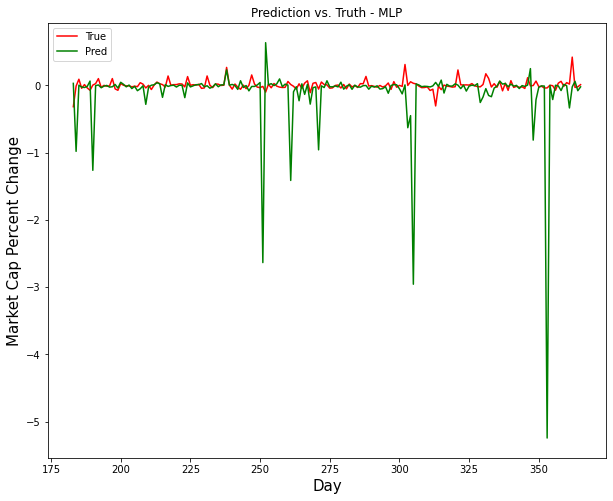

In [171]:
plt.figure(figsize=(10,8))
plt.title('Prediction vs. Truth - MLP')
plt.ylabel('Market Cap Percent Change',size=15)
plt.xlabel('Day',size=15)

idx = 1
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_true[len_test*idx:len_test*(idx+1)],color='red',label='True')
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_pred[len_test*idx:len_test*(idx+1)],color='green',label='Pred')
plt.legend()
plt.show()

In [152]:
rf_regr = RandomForestRegressor(max_depth=2, random_state=42)
rf_regr.fit(X_train, y_train)
print('MAE={}'.format(mean_absolute_error(y_true,rf_regr.predict(X_test))))
print('MSE={}'.format(mean_squared_error(y_true,rf_regr.predict(X_test))))
print('R2 Score={}'.format(r2_score(y_true,rf_regr.predict(X_test))))

MAE=0.07668312196136148
MSE=1.2687088537760098
R2 Score=-0.21805079687690965


In [128]:
rf_regr.feature_importances_

array([0.00943713, 0.29310809, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00506139,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01531311, 0.     

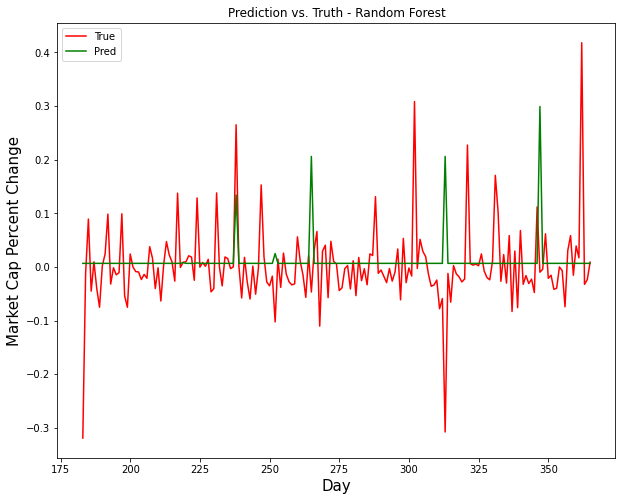

In [153]:
plt.figure(figsize=(10,8))
plt.title('Prediction vs. Truth - Random Forest')
plt.ylabel('Market Cap Percent Change',size=15)
plt.xlabel('Day',size=15)

idx = 1
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_true[len_test*idx:len_test*(idx+1)],color='red',label='True')
plt.plot(list(range(len_test*idx,len_test*(idx+1))),rf_regr.predict(X_test)[len_test*idx:len_test*(idx+1)],color='green',label='Pred')
plt.legend()

In [155]:
svr_reg = SVR()
svr_reg.fit(X_train, y_train)

SVR()

In [156]:
y_pred_svr = svr_reg.predict(X_test) 
y_true = y_test
print('MAE={}'.format(mean_absolute_error(y_true,y_pred_svr)))
print('MSE={}'.format(mean_squared_error(y_true,y_pred_svr)))
print('R2 Score={}'.format(r2_score(y_true,y_pred_svr)))

MAE=0.05890945806414687
MSE=1.041713363791205
R2 Score=-0.00011897064227484044


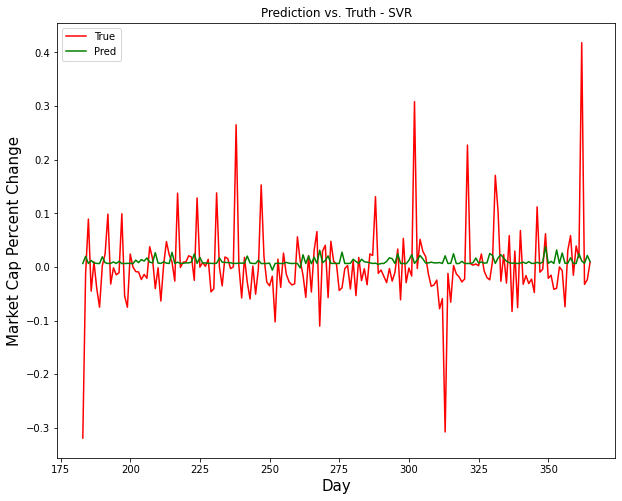

In [157]:
plt.figure(figsize=(10,8))
plt.title('Prediction vs. Truth - SVR')
plt.ylabel('Market Cap Percent Change',size=15)
plt.xlabel('Day',size=15)
idx = 1
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_true[len_test*idx:len_test*(idx+1)],color='red',label='True')
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_pred_svr[len_test*idx:len_test*(idx+1)],color='green',label='Pred')
plt.legend()

In [172]:
rid_reg = Ridge()
rid_reg.fit(X_train, y_train)
y_pred_ridge = rid_reg.predict(X_test)
y_true = y_test
print('MAE={}'.format(mean_absolute_error(y_true,y_pred_ridge)))
print('MSE={}'.format(mean_squared_error(y_true,y_pred_ridge)))
print('R2 Score={}'.format(r2_score(y_true,y_pred_ridge)))

MAE=0.06782598778344534
MSE=1.0336081695333539
R2 Score=0.007662592712654348


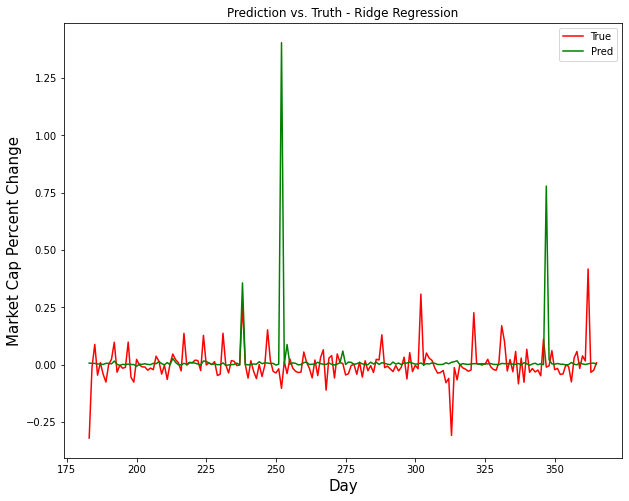

In [159]:
plt.figure(figsize=(10,8))
plt.title('Prediction vs. Truth - Ridge Regression')
plt.ylabel('Market Cap Percent Change',size=15)
plt.xlabel('Day',size=15)
idx = 1
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_true[len_test*idx:len_test*(idx+1)],color='red',label='True')
plt.plot(list(range(len_test*idx,len_test*(idx+1))),y_pred_ridge[len_test*idx:len_test*(idx+1)],color='green',label='Pred')
plt.legend()

## Causal Inference

In [21]:
uni_data = data[data['slug']=='uniswap']
before = uni_data[(uni_data['date']>='2020-09-17') & (uni_data['date']<='2021-06-20')]
after = uni_data[uni_data['date']>'2021-06-20']

In [43]:
X_before = np.array(list(range(1,len(before)+1))).reshape((-1,1))
y_before = before['marketcap_usd']
model_before = LinearRegression().fit(X_before, y_before)

In [45]:
X_after = np.array(list(range(1,len(after)+1))).reshape((-1,1))
y_after = after['marketcap_usd']
model_after = LinearRegression().fit(X_after, y_after)

In [47]:
lin_x_1 = list(range(len(before)))
lin_x_2 = list(range(len(before),len(before)+len(after)))
lin_y_1 = model_before.coef_*lin_x_1 + model_before.intercept_
lin_y_2 = model_after.coef_*lin_x_2 + model_after.intercept_

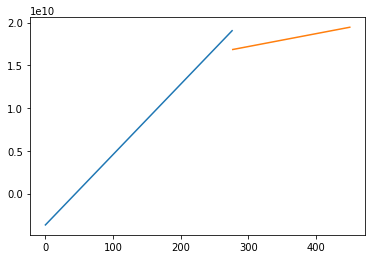

In [49]:
plt.plot(lin_x_1,lin_y_1)
plt.plot(lin_x_2,lin_y_2)